In [69]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt

In [60]:
# Mengatur parameter
batch_size = 32
img_height = 180
img_width = 180
num_classes = 26

In [ ]:
# Mengatur direktori dataset
train_dir = '../data/image/train'
val_dir = '../data/image/validation'
label_dir = '../data/image/label'

In [62]:
# Fungsi untuk memuat label dari file JSON
def load_labels(label_dir):
    labels = {}
    for file_name in os.listdir(label_dir):
        if file_name.endswith('.json'):
            file_path = os.path.join(label_dir, file_name)
            with open(file_path, 'r') as f:
                data = json.load(f)
                labels[file_name] = data
    return labels

In [63]:
# Memuat label
labels = load_labels(label_dir)
print(f"Loaded labels: {labels.keys()}")

Loaded labels: dict_keys(['A.json', 'B.json', 'C.json', 'D.json', 'E.json', 'F.json', 'G.json', 'H.json'])


In [64]:
# Menggunakan ImageDataGenerator untuk augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2851 images belonging to 26 classes.
Found 2851 images belonging to 26 classes.


In [66]:
# Menggunakan Transfer Learning dengan VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
# Callback untuk learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.1583 - loss: 3.1575 - val_accuracy: 0.5886 - val_loss: 2.0668 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.3079 - loss: 2.5507 - val_accuracy: 0.6422 - val_loss: 1.7264 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.3444 - loss: 2.3712 - val_accuracy: 0.7068 - val_loss: 1.4672 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.4097 - loss: 2.1819 - val_accuracy: 0.7285 - val_loss: 1.2620 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 343s 4s/step - accuracy: 0.4019 - loss: 2.0731 - val_accuracy: 0.7706 - val_loss: 1.2065 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.4365 - loss: 1.9441 - val_accuracy: 0.7906 - val_loss: 1.0898 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.4800 - loss: 1.8754 - val_acc

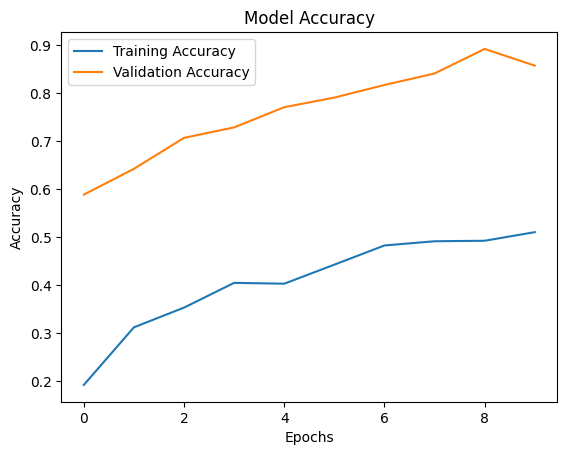

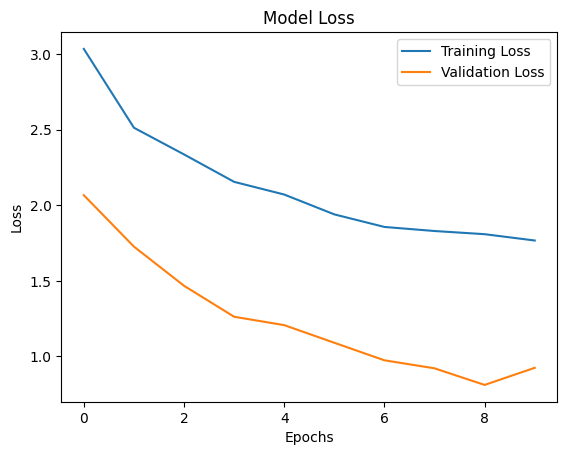

In [71]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[lr_scheduler, checkpoint, early_stopping]
)

# Evaluasi model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Menampilkan grafik akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Menampilkan grafik loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [72]:
# Menyimpan model
model.save('final_model.keras')
# Menyimpan model ke format HDF5
model.save('final_model.h5')
# Menyimpan arsitektur model ke format JSON
model_json = model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
